In [ ]:
!pip install -qU \
  langchain \
  langchain-community \
  langchain-core \
  langgraph \
  tiktoken \
  pinecone-client==3.0.0 \
  langchain-openai \
  langchain-anthropic \
  pinecone-text \
  langchainhub

In [ ]:
# Required API Keys:

OPENAI_API_KEY = ""
ANTHROPIC_API_KEY = ""
JINA_API_KEY = ""
PINE_API_KEY = ""

# Optional:
LANGCHAIN_API_KEY = ""

In [ ]:
from langchain_openai import OpenAIEmbeddings

embed = OpenAIEmbeddings(
    model='text-embedding-3-small',
    openai_api_key=OPENAI_API_KEY,
    dimensions = 768
)

In [ ]:
import os

os.environ['LANGCHAIN_TRACING_V2'] = "true"

os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"

os.environ['LANGCHAIN_PROJECT'] = "rag-pro"

os.environ['LANGCHAIN_API_KEY'] = LANGCHAIN_API_KEY

In [ ]:
from pinecone import Pinecone
import time

PINE_API_KEY = PINE_API_KEY

index_name='bm25'

namespace_name='rag-pro'

pc = Pinecone(api_key=PINE_API_KEY)

index = pc.Index(index_name)
# wait a moment for connection
time.sleep(1)

index.describe_index_stats()

In [ ]:
index.describe_index_stats()

# Custom Pinecone Hybrid Search

This is a retrieval technique which allows the user to easily change how many chunks are returned while mantaining the size of the chunk which is searched on.  Meaning if you are searching on chunks that are 100 tokens, then you can return the exact relevant chunks of 100 tokens by setting `layers=0`.

If you set `layers=2`, then 5 chunks will be returned in the 'page_content' variable with the relevant chunk being in the middle of the 5 chunks.

Here's a visual of this:

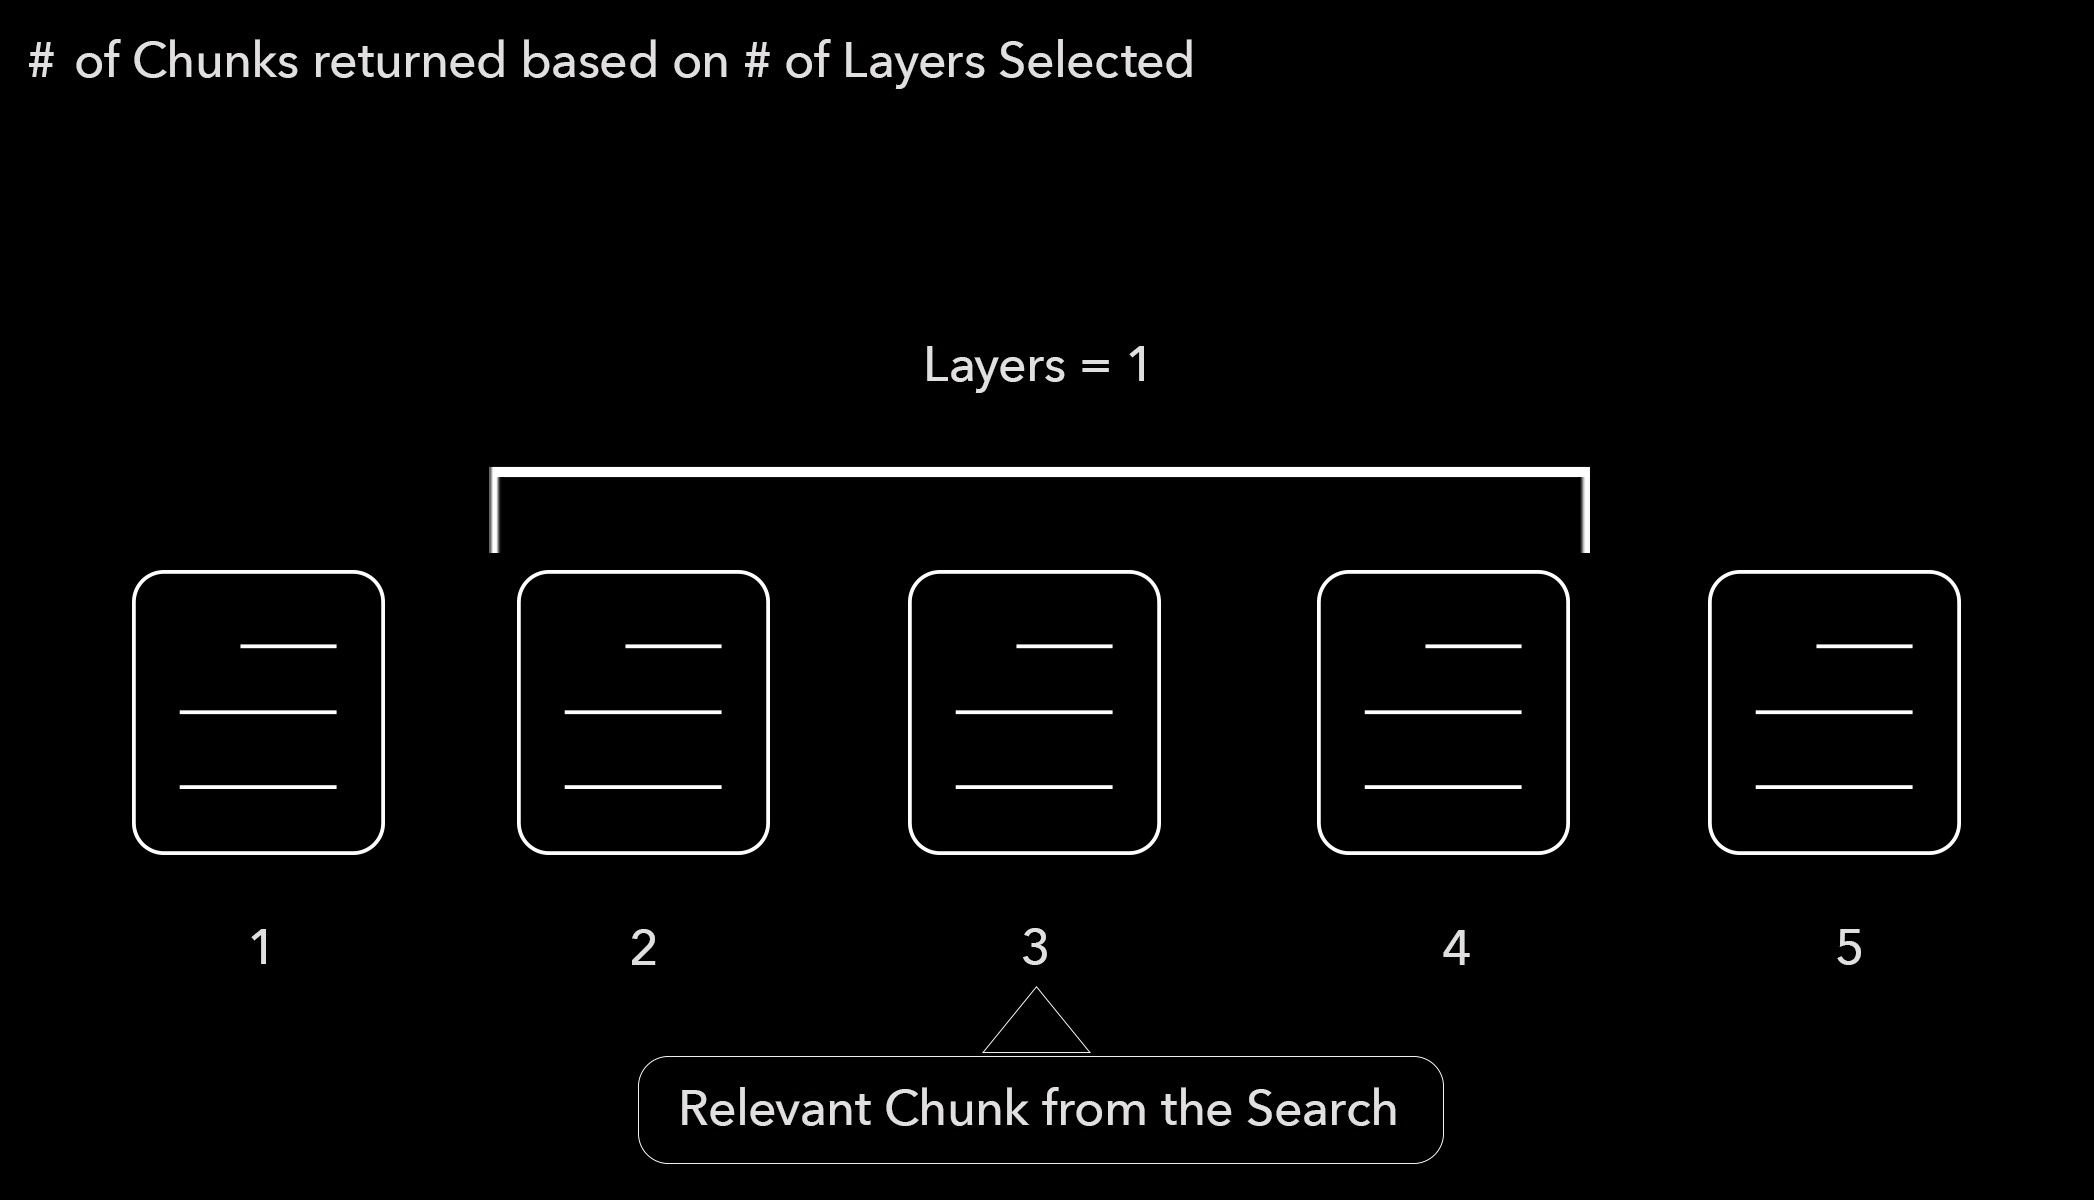

In [ ]:
from typing import Any, Dict, List, Optional
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.retrievers import BaseRetriever
from langchain_core.utils import pre_init
from pinecone_text.sparse import BM25Encoder
from pinecone_text.hybrid import hybrid_convex_scale

class PineconeHybridSearchRetriever(BaseRetriever):
    embeddings: Embeddings
    sparse_encoder: Any
    index: Any
    top_k: int = 4
    alpha: float = 0.5
    namespace: Optional[str] = None
    layers: int = 1

    class Config:
        arbitrary_types_allowed = True
        extra = "forbid"

    @pre_init
    def validate_environment(cls, values: Dict) -> Dict:
        try:
            from pinecone_text.hybrid import hybrid_convex_scale
            from pinecone_text.sparse.base_sparse_encoder import BaseSparseEncoder
        except ImportError:
            raise ImportError(
                "Could not import pinecone_text python package. "
                "Please install it with `pip install pinecone_text`."
            )
        return values

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun, **kwargs: Any
    ) -> List[Document]:
        sparse_vec = self.sparse_encoder.encode_queries(query)
        dense_vec = self.embeddings.embed_query(query)
        dense_vec, sparse_vec = hybrid_convex_scale(dense_vec, sparse_vec, self.alpha)
        sparse_vec["values"] = [float(s1) for s1 in sparse_vec["values"]]

        result = self.index.query(
            vector=dense_vec,
            sparse_vector=sparse_vec,
            top_k=self.top_k,
            include_metadata=True,
            namespace=self.namespace,
            **kwargs,
        )

        if not result["matches"]:
            return []

        final_documents = []

        for match in result["matches"]:
            child_id = match["metadata"].get("child_id")

            if not child_id:
                final_documents.append(Document(page_content=match["metadata"].get("context", ""),
                                                metadata={'source': match["metadata"].get('source', '')}))
                continue

            parts = child_id.split('-')
            base_id = f"{parts[0]}-{parts[1]}-"
            center_num = int(parts[2])

            # Generate list of child_ids to retrieve
            child_ids_to_retrieve = [
                f"{base_id}{i}"
                for i in range(center_num - self.layers, center_num + self.layers + 1)
            ]

            # Query for all contexts at once
            all_contexts = self.index.query(
                vector=dense_vec,
                sparse_vector=sparse_vec,
                filter={"child_id": {"$in": child_ids_to_retrieve}},
                top_k=len(child_ids_to_retrieve),
                include_metadata=True,
                namespace=self.namespace,
            )

            # Sort the results to ensure correct order
            sorted_contexts = sorted(all_contexts["matches"], key=lambda x: x["metadata"]["child_id"])

            combined_content = "\n".join([ctx["metadata"].get("context", "") for ctx in sorted_contexts])

            metadata = {
                'child_id': ",".join(child_ids_to_retrieve),
                'source': match["metadata"].get('source', ''),
                'score': match.get('score', 0),
                'center_chunk': child_id
            }

            final_documents.append(Document(page_content=combined_content.strip(), metadata=metadata))

        return final_documents

# Initialize the retriever
bm25_encoder = BM25Encoder().default()

In [ ]:
retriever = PineconeHybridSearchRetriever(
    embeddings=embed,
    sparse_encoder=bm25_encoder,
    index=index,
    namespace=namespace_name,
    top_k=4,  # How many chunks to search for
    layers=3  # How many layers to be returned for each chunk
)

In [ ]:
# test
result = retriever.invoke("embeddings")
result

Optionally add a ReRanker

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain_community.document_compressors import JinaRerank
import os

os.environ['JINA_API_KEY'] = JINA_API_KEY

compressor = JinaRerank()
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

compressed_docs = compression_retriever.get_relevant_documents(
    "what does a reranker do?"
)

In [ ]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

pretty_print_docs(compressed_docs)

# Chat using an Anthropic LLM and Langgraph

In [ ]:
# First we initialize the model we want to use.
from langchain_anthropic import ChatAnthropic

model = ChatAnthropic(temperature=0, anthropic_api_key=ANTHROPIC_API_KEY, model_name="claude-3-haiku-20240307")


from langchain.tools.retriever import create_retriever_tool


subject = "Langchain Docs"

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_context",
    f"Search and return information about {subject} from a {subject} study pakcet dense with information about everything {subject}.",
)

tools = [retriever_tool]

# We can add our system prompt here

prompt = "System Prompt here..."

# Define the graph

from langgraph.prebuilt import create_react_agent

graph = create_react_agent(model, tools=tools, messages_modifier=prompt)

In [ ]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [ ]:
inputs = {"messages": [("user", "how can I see the traces from my LLM application")]}

print_stream(graph.stream(inputs, stream_mode="values"))